In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import torch
from entmax import entmax_bisect, entmax15, sparsemax
from torch.nn.functional import softmax
from tqdm import tqdm

np.random.seed(seed=3154) # Set seed for reproducibility
mpl.rcParams['text.usetex'] = True # Enable LaTeX rendering

# Algorithms

In [2]:
def log_alpha(Pi, alpha):
    if alpha == 1:
        return np.log(Pi)
    return (pow(Pi, alpha - 1) - 1)/(alpha - 1)
    
def tsallis_entropy(Pi, alpha):
    return - Pi * log_alpha(Pi, alpha) / alpha
    
# Tsallis Regularized Value Iteration
def Tsallis(S, A, T0, P, R, V0, gamma, lamb=1, alpha=1, verbose=True):
    V  = V0
    # Save state value functions
    vs = list()
    for i in tqdm(range(1, T0), disable=not verbose):
        # Compute Q
        Q  = R + gamma * np.matmul(P, V)
        Q  = Q.reshape(S, A)

        if lamb:
            if alpha==1:
                Pi = softmax(torch.tensor(Q/lamb), dim=1)
            elif alpha==1.5:
                Pi = entmax15(torch.tensor(Q/lamb))
            elif alpha==2:
                Pi = sparsemax(torch.tensor(Q/lamb))
            else:
                Pi = entmax_bisect(torch.tensor(Q/lamb), alpha=alpha)
            Pi = np.array(Pi)
        else:
            # Compute policy using Dirac distribution (deterministic policy)
            Pi = np.zeros((S, A))
            idx = np.argmax(Q, axis=1)
            Pi[np.arange(S), idx] = 1

        # Compute V
        delta = 1e-4 * int(alpha==1)
        V  = np.sum(Pi * Q + lamb * tsallis_entropy(Pi, alpha + delta), axis=1)
        vs.append(V)
        V  = V[:, np.newaxis]
    return vs, Pi

# Value iteration for standard MDP
def value_iteration(S, A, T0, P, R, V0, gamma):
    V = V0
    vs = []
    
    for _ in tqdm(range(1, T0)):
        # Compute Q-values: Q(s, a) = R(s, a) + gamma * sum_s' P(s'|s, a) * V(s')
        Q = R + gamma * np.matmul(P, V)
        Q = Q.reshape(S, A)

        # Compute greedy deterministic policy: Pi(s, a) = 1 if a = argmax(Q(s, a)), else 0
        Pi = np.zeros((S, A))
        idx = np.argmax(Q, axis=1)  # Deterministic policy (greedy)
        Pi[np.arange(S), idx] = 1

        # Update value function: V(s) = max_a Q(s, a)
        V = np.max(Q, axis=1)
        
        vs.append(V)
        V = V[:, np.newaxis]  # Reshape to (S, 1) for next iteration

    return vs, Pi

def policy_evaluation(S, A, P, R, gamma, Pi, tolerance=1e-6, max_iterations=1000):
    V = np.zeros(S)
    iteration = 0

    while iteration < max_iterations:
        V_new = np.zeros(S)
        
        for s in range(S):
            V_new[s] = sum(Pi[s, a] * (R[s * A + a] + gamma * np.dot(P[s * A + a], V)) for a in range(A))
        
        delta = np.max(np.abs(V - V_new))
        V = V_new
        iteration += 1 

        if delta < tolerance:
            break
    
    if iteration == max_iterations:
        print("Warning: Maximum iterations reached without convergence.")

    return V

# Random MDP

In [3]:
def setup_random_mdp(S, A, seed=3154, l_r=0, h_r=1):
    '''
    Setup random MDP.
        S  - State space cardinality
        A  - Action space cardinality
        R  - Reward function
    '''
    # set random seed for reproducibility
    np.random.seed(seed=seed)
    sparse = np.random.binomial(1, 0.05, size=(S*A, S))
    # Check that there are no terminal states
    for i in range(A*S):
        if sum(sparse[i, :]) == 0:
            sparse[i, np.random.randint(S)] = 1

    # Generate Transition Matrix 
    P = sparse * np.random.uniform(0, 1, size=(S*A, S)) # P(s'|s, a) = P[s * |A| + (a - 1), s']
    # Normalize
    P /= np.sum(P, 1)[:, np.newaxis]

    # Generate uniformm rewards
    R = np.random.uniform(low=l_r, high=h_r, size=(S*A, 1)) # R(s, a) = R[S*A-1]

    return P, R

In [4]:
A     = 5     # Action Space cardinality
S     = 10    # State Space cardinality
T0    = 100   # Value Iteration iterations
gamma = 0.90  # Discount Factor

# Get environments transition matrix and reward function
P, R = setup_random_mdp(S=S, A=A, l_r=0, h_r=1)

# Bounds

In [5]:
# Upper Bound
V0 = np.random.uniform(low=0, high=0.1, size=(S, 1))/(1-gamma)
vs, Pi_star = value_iteration(S, A, T0, P, R, V0, gamma) # vs is the 'history' of V(s)

upper_bound = np.array(vs[-1]).mean()
print(f'Upper Bound: {upper_bound}')
# lower bound depends on the alpha value

100%|█████████████████████████████████████████| 99/99 [00:00<00:00, 9192.13it/s]

Upper Bound: 8.91626492171463


In [6]:
# Define alphas to iterate over
alphas = np.linspace(1.01, 10, 100)

# Initial parameters
T0 = 100  # Number of iterations for Tsallis
V0 = np.zeros((S, 1))  # Initial value function

unreg_values = list()
lower_bounds = list()

# Loop over each alpha value
for alpha in tqdm(alphas):
    vs, Pi = Tsallis(S, A, T0, P, R, V0, gamma, lamb=1, alpha=alpha, verbose=False)
    V_evaluated = policy_evaluation(S, A, P, R, gamma, Pi) # unregularized value - for performance
    unreg_values.append(V_evaluated.mean())
    lower_bounds.append(upper_bound + log_alpha(1/A, alpha)/(alpha*(1-gamma)))

  0%|                                                   | 0/100 [00:00<?, ?it/s]/var/folders/rc/9n3vn3bn6nn7dl_qpr6080qh0000gn/T/ipykernel_46840/2407023241.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V_new[s] = sum(Pi[s, a] * (R[s * A + a] + gamma * np.dot(P[s * A + a], V)) for a in range(A))
100%|█████████████████████████████████████████| 100/100 [00:40<00:00,  2.48it/s]


In [7]:
def plot_performance_comparison(alpha_values, J_pi_q_star, J_pi_star_mean, lower_bound=None):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(alpha_values, J_pi_q_star, label=r"$\pi_{\alpha}^*$", color='red', linewidth=3)
    ax.plot(alpha_values, [J_pi_star_mean] * len(alpha_values), 'b--', label="Upper Bound", linewidth=3)

    if lower_bound is not None:
        ax.plot(alpha_values, lower_bound, 'g-.', label="Lower Bound", linewidth=3)

    ax.set_xlabel(r"$\alpha$", fontsize=18)
    ax.set_ylabel("Performance", fontsize=18)

    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.yaxis.grid(True, color='gray', linestyle='--', linewidth=0.5)
    ax.xaxis.grid(False) 

    ax.legend(loc='lower right', frameon=False, fontsize=14)

    ax.set_ylim(0, 10)

    # Save and show the plot
    plt.tight_layout()
    plt.savefig(f'performance_plot_alpha.pdf')
    plt.show()

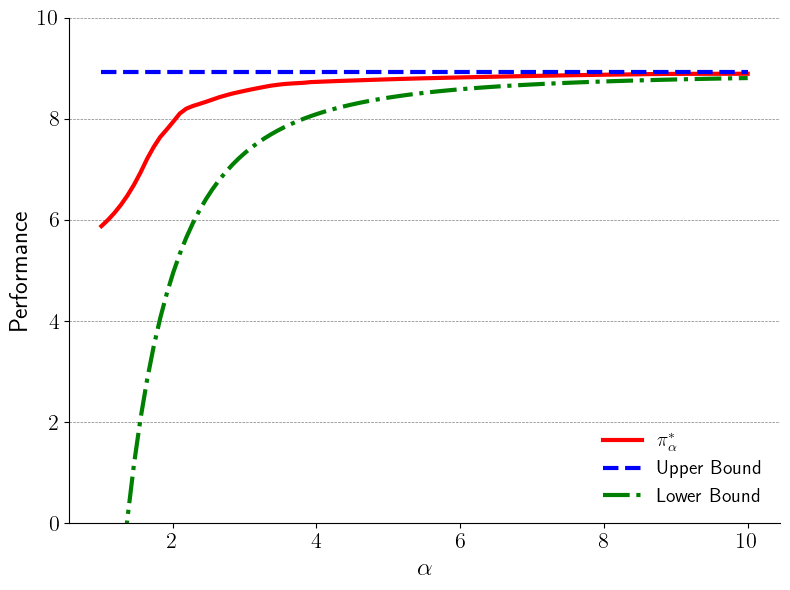

In [8]:
plot_performance_comparison(alphas, unreg_values, upper_bound, lower_bounds)

# Bounds with Increasing Action Space

In [9]:
disc   = np.logspace(1, 10, 1000)
alphas = [1, 1.5, 2, 3, 4, 5]

def entropy_bound_term(alpha, A):
    return log_alpha(1/A, alpha)/(alpha*(1 - 0.9))

/var/folders/rc/9n3vn3bn6nn7dl_qpr6080qh0000gn/T/ipykernel_46840/2485005637.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('coolwarm', len(alphas))


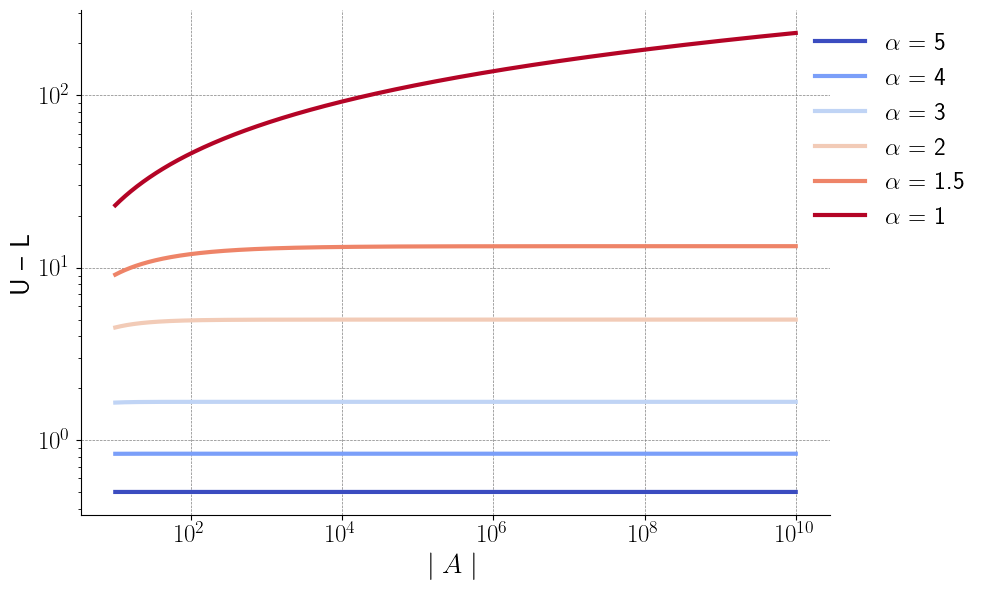

In [10]:
def plot_entropy_bound(alphas, disc, fontsize_multiplier=1):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    color_map = cm.get_cmap('coolwarm', len(alphas))
    
    alphas.reverse()
    for i, alpha in enumerate(alphas):
        entropy_values = -entropy_bound_term(alpha, disc)
        label = f'$\\alpha$ = {alpha}'
        color = color_map(i)  # Color from colormap
        ax.plot(disc, entropy_values, label=label, linewidth=3, color=color)
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'$\mid A \mid$', fontsize=20 * fontsize_multiplier)
    ax.set_ylabel('U -- L', fontsize=20 * fontsize_multiplier)
    ax.legend(loc='upper right', frameon=False, fontsize=18 * fontsize_multiplier, bbox_to_anchor=(1.21, 1))
    ax.tick_params(axis='both', which='major', labelsize=18 * fontsize_multiplier)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, color='gray', linestyle='--', linewidth=0.5)
    ax.xaxis.grid(True, color='gray', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.savefig('U_L.pdf')
    plt.show()

plot_entropy_bound(alphas=alphas, disc=disc, fontsize_multiplier=1)